In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from cellpose import io
from liams_funcs import *
from features import *

import pandas as pd

In [2]:
control_dir = '../control_images/'
penetramax_dir = '../penetramax_images/'

control_fnames = [control_dir + fname for fname in os.listdir(control_dir)]
penetramax_fnames = [penetramax_dir + fname for fname in os.listdir(penetramax_dir)]

In [30]:
fname1 = '../control_images/001_z26.png'
fname2 = '../penetramax_images/011_z57.png'

In [40]:
data = np.load('../segments/penetramax/011_z57.png.npy')
image = io.imread('../penetramax_images/011_z57.png')

reds, blues = image[:,:,0], image[:,:,2]
combined_cells, combined_nuclei = data[:,:,0], data[:,:,1]

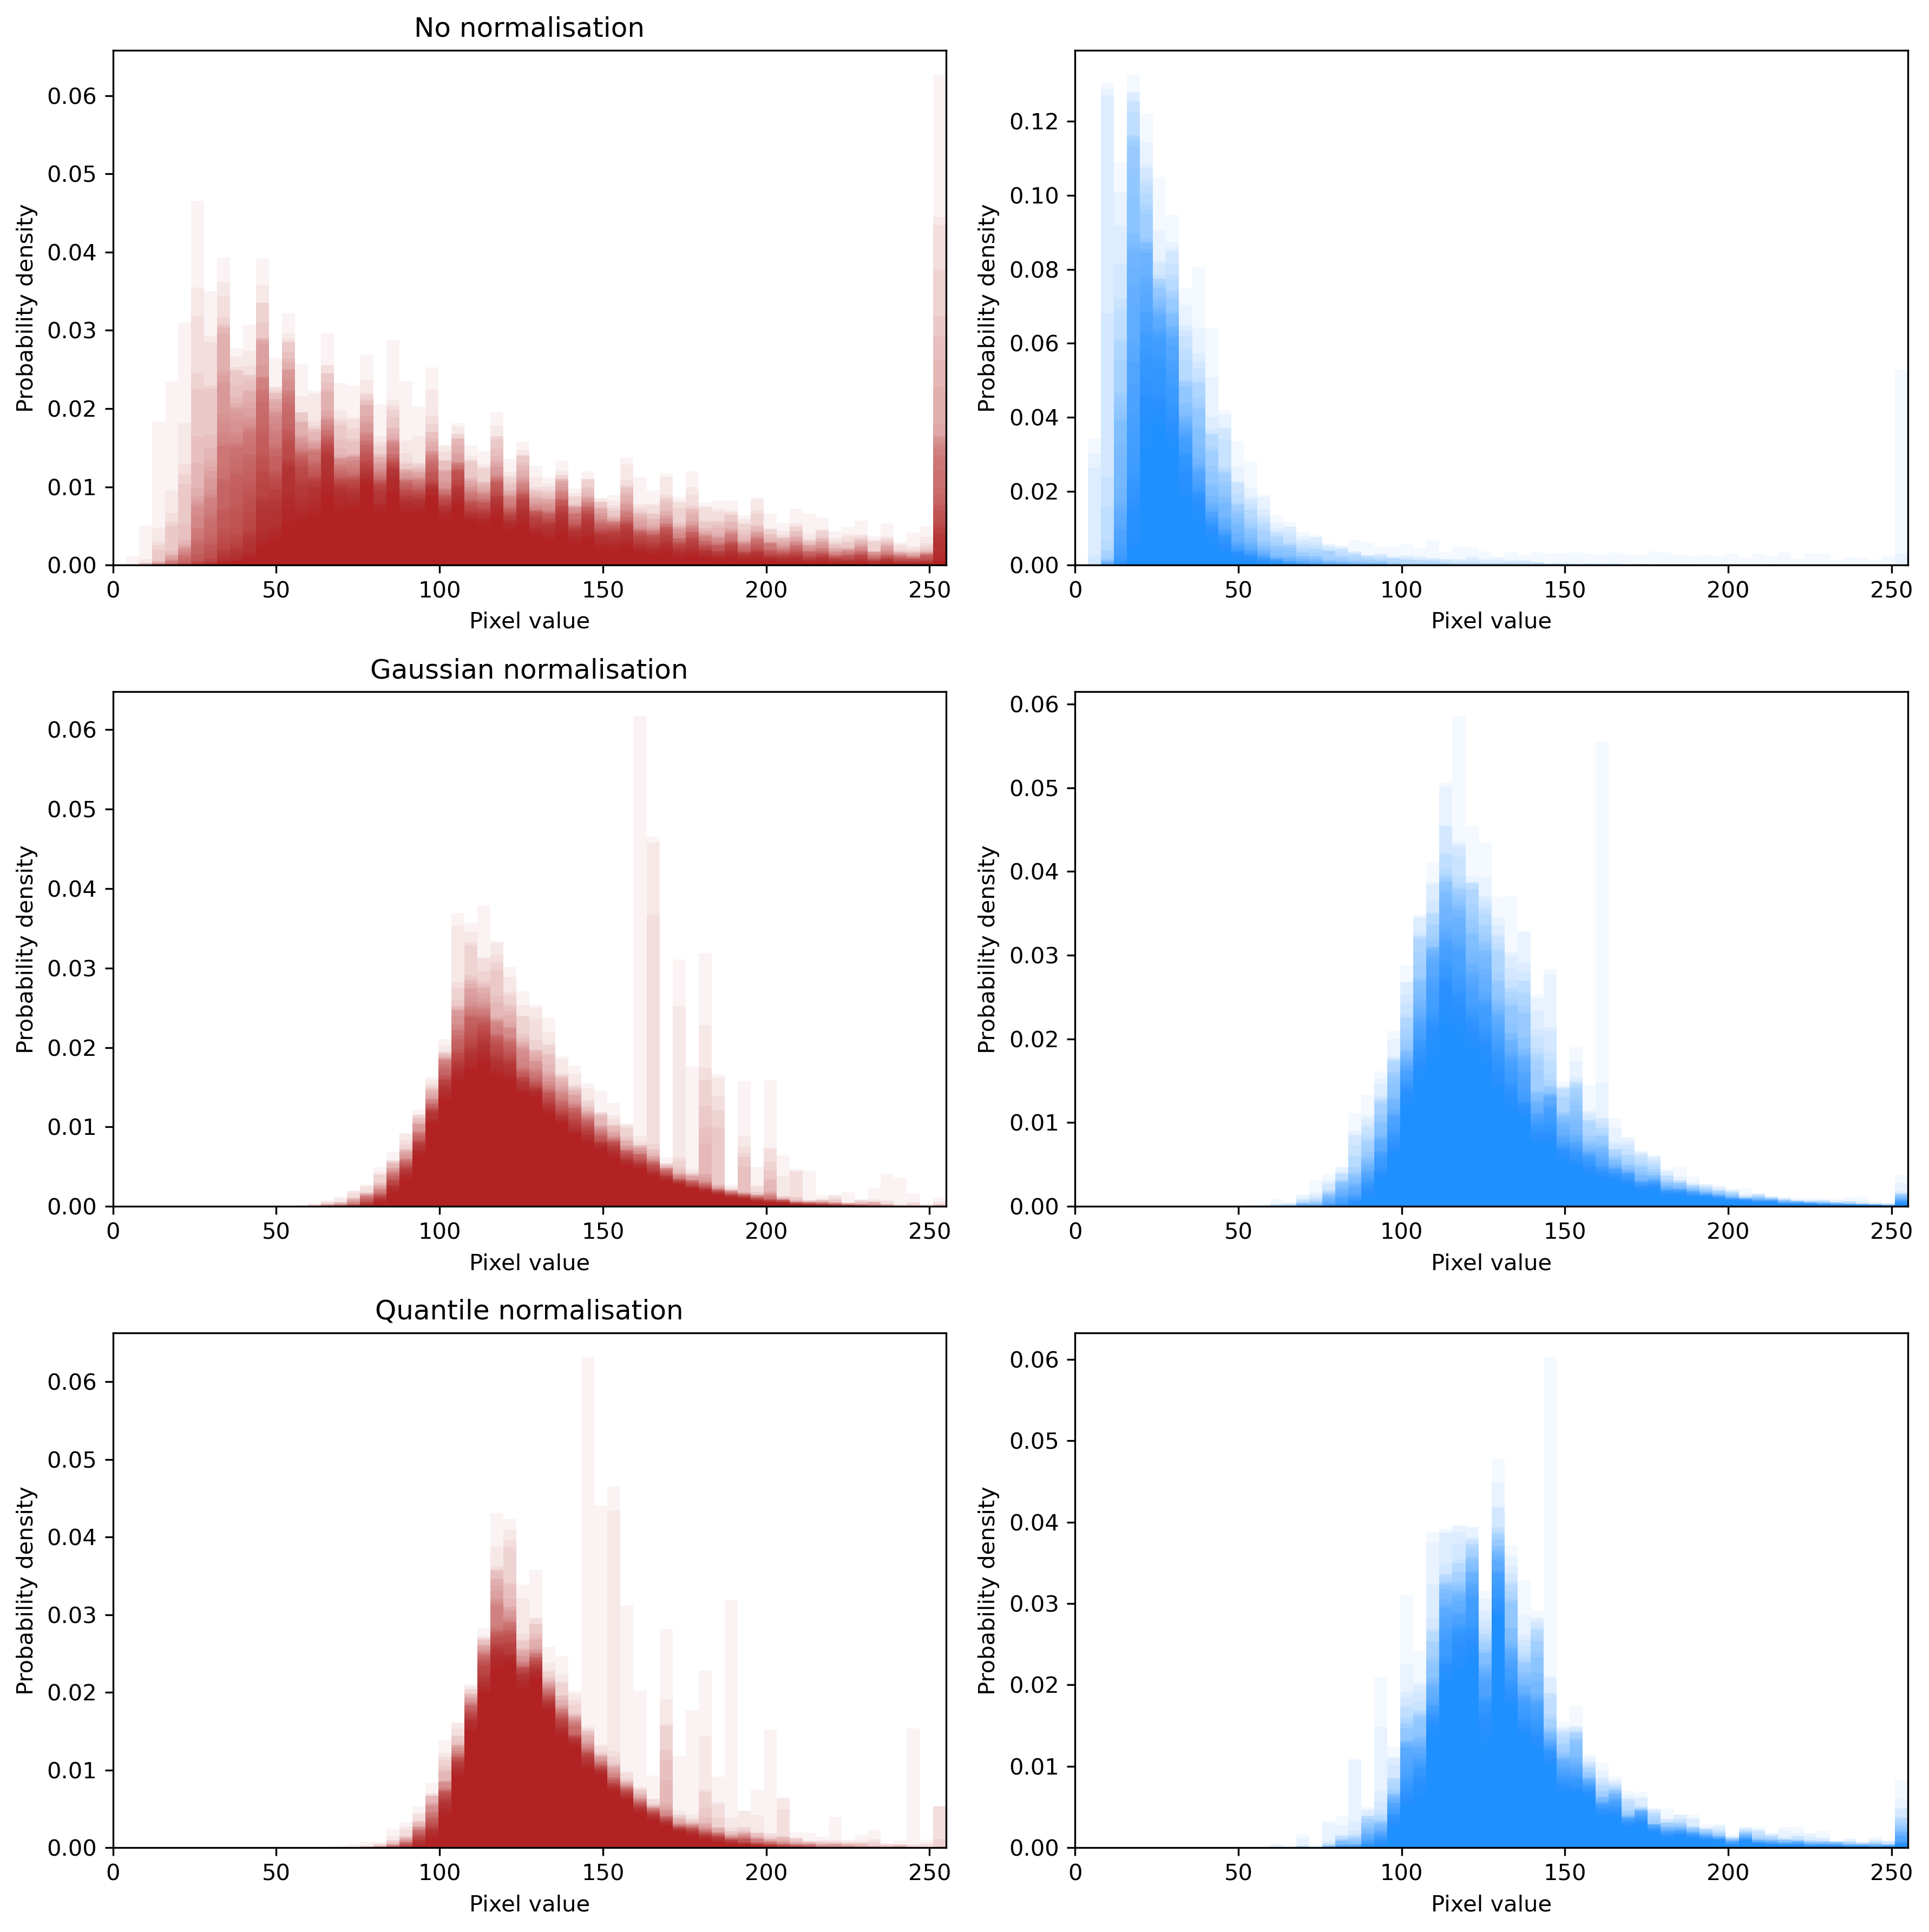

In [41]:
vals = np.arange(1, combined_nuclei.max()+1)
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=300)

for val in vals:
    mask = (combined_nuclei == val)
    red = reds[mask]
    blue = blues[mask]

    counts_red, edges = np.histogram(red, bins=64, range=(0,255), density=True)
    counts_blue, _ = np.histogram(blue, bins=64, range=(0,255), density=True)

    axes[0,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[0,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(ZtoRGB(gaussian_normalisation(red)), bins=64, range=(0, 255), density=True)
    counts_blue, _= np.histogram(ZtoRGB(gaussian_normalisation(blue)), bins=64, range=(0, 255), density=True)

    axes[1,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[1,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(ZtoRGB(quantile_normalisation(red)), bins=64, range=(0, 255), density=True)
    counts_blue, _ = np.histogram(ZtoRGB(quantile_normalisation(blue)), bins=64, range=(0, 255), density=True)

    axes[2,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[2,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

for ax in axes.flatten():
    ax.set_ylim(0)
    ax.set_ylabel('Probability density')
    ax.set_xlabel('Pixel value')
    ax.set_xlim(0, 255)
    
axes[0,0].set_title('No normalisation'); axes[1,0].set_title('Gaussian normalisation'); axes[2,0].set_title('Quantile normalisation')

plt.tight_layout()
plt.savefig('../figures/spectrum_normalisations.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
ds = Dataset(control_fnames, penetramax_fnames)

Instantiating masks...


2it [00:07,  3.62s/it]


Retrieving features...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]

     getAreaOfHoles  getCellArea  getCellAreaBbox  getCellAreaConvex  \
0          0.458376      10709.0          33048.0            13426.0   
1          0.459766      19954.0          51993.0            22351.0   
2          0.437995      10459.0          21746.0            10958.0   
3          0.472988       9415.0          14541.0            10398.0   
4          0.471160      19282.0          40600.0            22413.0   
..              ...          ...              ...                ...   
144        0.440279       5024.0           7840.0             5157.0   
145        0.431238       3128.0           6230.0             3451.0   
146        0.431105       4991.0           9086.0             5387.0   
147        0.451439       5930.0           8094.0             6177.0   
148        0.432288       2460.0           3900.0             2697.0   

     getCellAxisMajor  getCellAxisMinor  getCellDiam  getCellEcc  \
0          252.823575         61.903436   116.769526    0.969561   

In [8]:
def get_generations(levels):
    from numpy import array
    return array([l // 1000 for l in levels])

levels = [1, 2, 4, 5, 1000, 1001, 2001]

get_generations(levels)

array([0, 0, 0, 0, 1, 1, 2])

In [4]:
ds.performDimReduction()
ds.makeKDE()
ds.makeSelection()

,getAreaOfHoles,getCellArea,getCellAreaBbox,getCellAreaConvex,getCellAxisMajor,getCellAxisMinor,getCellDiam,getCellEcc,getCellFeretDiam,getCellMaxR,...,getNucleusRoundness,getNucleusSolidity,getNucleusStdR,getQ05,getQ25,getQ50,getQ75,getQ95,getSegmentOrder,label
0,0.458376,10709.0,33048.0,13426.0,252.823575,61.903436,116.769526,0.969561,259.131241,214.0,...,0.746689,0.974181,17.333734,101.0,115.0,126.0,138.0,157.0,0,0
2,0.437995,10459.0,21746.0,10958.0,202.430275,67.798270,115.398494,0.942246,200.384630,234.0,...,0.666792,0.974739,21.019875,95.0,112.0,126.0,140.0,163.0,0,0
3,0.472988,9415.0,14541.0,10398.0,125.502863,98.063919,109.487672,0.624071,136.000000,254.0,...,0.895175,0.982745,21.750556,103.0,113.0,123.0,133.0,169.0,0,0
4,0.471160,19282.0,40600.0,22413.0,245.986678,111.593571,156.686326,0.891176,270.118493,203.0,...,0.844489,0.985570,19.620618,94.0,114.0,127.0,140.0,159.0,0,0
5,0.433425,7209.0,8610.0,7328.0,109.038122,85.384997,95.805970,0.621928,115.485930,205.0,...,0.885588,0.980919,20.377158,94.0,113.0,126.0,140.0,162.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.440279,5024.0,7840.0,5157.0,94.660385,70.016158,79.979719,0.672985,99.824847,174.0,...,0.836208,0.974458,22.667834,95.0,108.0,124.0,148.0,164.0,0,1
145,0.431238,3128.0,6230.0,3451.0,96.602216,43.202841,63.108583,0.894422,105.688221,207.0,...,0.727483,0.964586,22.625689,97.0,110.0,123.0,141.0,173.0,0,1
146,0.431105,4991.0,9086.0,5387.0,106.982764,70.217779,79.716614,0.754459,122.262014,170.0,...,0.834274,0.980739,23.302200,90.0,109.0,126.0,148.0,161.0,0,1
147,0.451439,5930.0,8094.0,6177.0,110.092990,73.368844,86.892523,0.745571,118.928550,182.0,...,0.825426,0.979963,22.775218,90.0,109.0,129.0,142.0,167.0,0,1


In [83]:
ds.makeKDE()

In [34]:
dfs = []
for m in ms:
    dfs.append(m.getDataFrame())
df = pd.concat(dfs)

df.to_csv('features.csv', index=False)

In [35]:
X = df.drop('label', axis=1).to_numpy()
X_labels = df.drop('label', axis=1).columns

y = df['label'].to_numpy()

In [36]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=3).fit_transform(X)

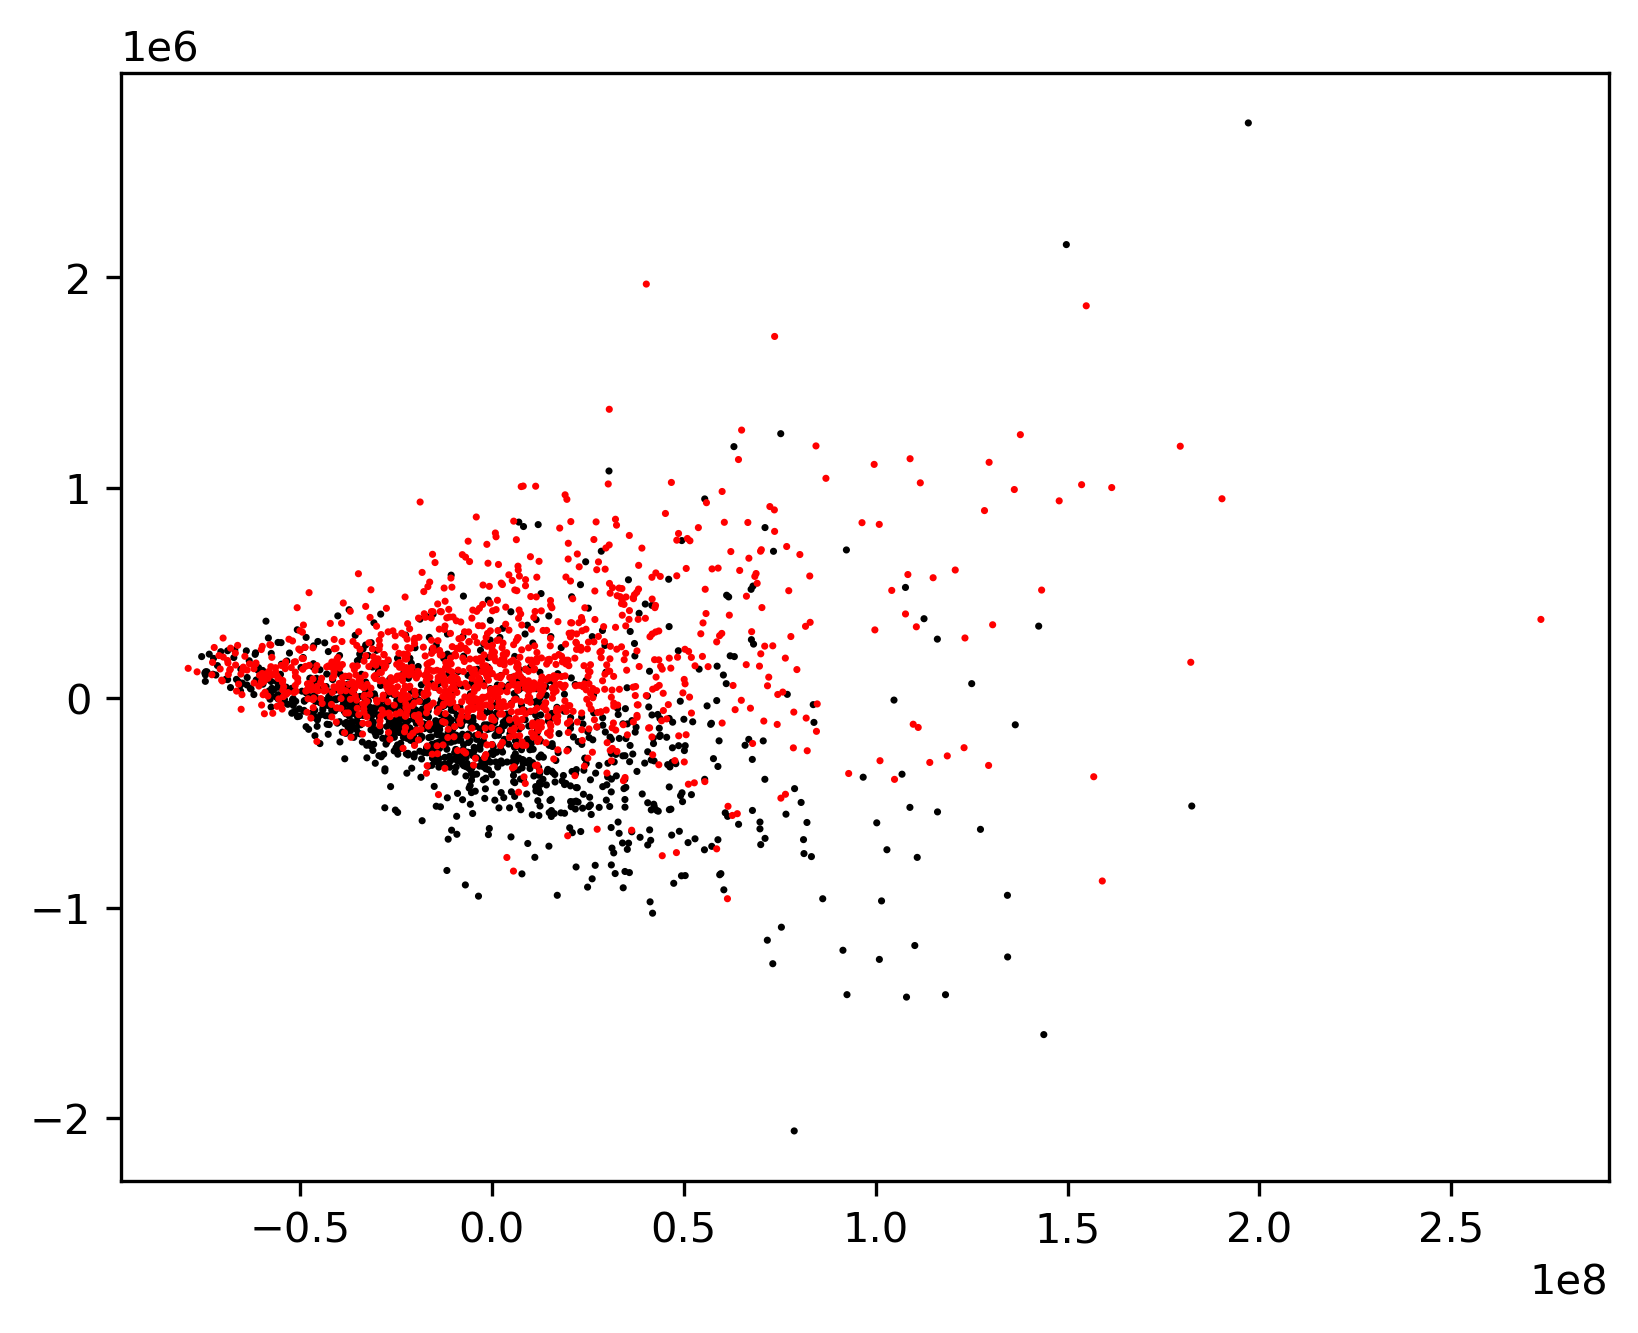

In [37]:
plt.figure(dpi=300)
plt.scatter(X_pca[:,0], X_pca[:,1], s=0.5, c=['k' if val==0 else 'r' for val in y])
plt.show()